### Instructions
This notebook runs all the modelling and saves them as pickle files
IMPORTANT: Make sure you have pandas >= 1.5.0 in order to read in the pickle files

1. Run first cell and function definition cells

In [40]:
import pandas as pd
import numpy as np
import pickle
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score, recall_score, precision_recall_curve, roc_curve
import matplotlib.pyplot as plt

features_all = pd.read_csv('features_all_weeks.csv')
features_all.drop(columns = ['Unnamed: 0', 'X1', 'X'], inplace = True)
# display(features_all)
print(features_all.info())

unclean_train_df = features_all[features_all['week'] != 8]
unclean_test_df = features_all[features_all['week'] == 8]

unclean_train_df.drop(columns = ['week'], inplace = True)
unclean_test_df.drop(columns = ['week'], inplace = True)

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 274529 entries, 0 to 274528
Data columns (total 28 columns):
 #   Column                 Non-Null Count   Dtype  
---  ------                 --------------   -----  
 0   playId                 274529 non-null  int64  
 1   gameId                 274529 non-null  int64  
 2   frameId                274529 non-null  int64  
 3   area_block             274529 non-null  float64
 4   dist_block             274529 non-null  float64
 5   dist_to_qb_block       274529 non-null  float64
 6   x_force_block          274529 non-null  float64
 7   y_force_block          274529 non-null  float64
 8   norm_weighted_x_block  274529 non-null  float64
 9   norm_weighted_y_block  274529 non-null  float64
 10  area_rush              274529 non-null  float64
 11  dist_rush              274529 non-null  float64
 12  dist_to_qb_rush        274529 non-null  float64
 13  x_force_rush           274529 non-null  float64
 14  y_force_rush           274529 non-nu

C:\Users\Harrison\AppData\Local\Temp\ipykernel_8404\112826384.py:16: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  unclean_train_df.drop(columns = ['week'], inplace = True)
C:\Users\Harrison\AppData\Local\Temp\ipykernel_8404\112826384.py:17: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  unclean_test_df.drop(columns = ['week'], inplace = True)


Python 3.8.10


In [2]:
def get_features(df, features = 'all', response = 'bad_thing'):
    """
    Gets relevant features depending on what we want to use for modelling.
    There are 2 types of features: distance features and force features. 
    Force features can also be decomposed to simple forces, weighted forces, and partitioned forces
    TODO: missing net forces
    """
    y = df['bad_thing']
    x = df.drop(columns = ['bad_thing', 'hit', 'hurry', 'sack', 'playId', 'gameId', 'frameId'])
    if features == 'all':
        return (x, y)
    elif features == 'distance':
        x = x[['area_block', 'dist_block', 'dist_to_qb_block', 'area_rush', 'dist_rush', 'dist_to_qb_rush']]
    
    elif features == 'force_simple':
        x = x[['x_force_block', 'y_force_block', 'x_force_rush', 'y_force_rush']]
    
    elif features == 'force_weighted':
        x = x[['norm_weighted_x_block', 'norm_weighted_y_block', 'norm_weighted_x_rush', 'norm_weighted_y_rush']]
    
    elif features == 'force_partitioned':
        x = x[['net_x_force_bottom', 'net_y_force_bottom', 'net_x_force_middle', 'net_y_force_middle', 
               'net_x_force_top', 'net_y_force_top']]
    elif features == 'force_all':
        x = x.drop(columns = ['area_block', 'dist_block', 'dist_to_qb_block', 'area_rush', 'dist_rush', 'dist_to_qb_rush'])
    
    return (x, y)

# keep track of frameID
def df_split_by_frame(df, group_by = 5, features = 'all'):
    """
    Helper function to get separate dataframes for each frameID. Also keeps track of which set of features we're using
    for naming the model later on
    """
    df_grouped = df.groupby('frameId')
    df_dict = dict()

    for n, df in df_grouped:
        if (n % group_by == 1 and n < 60):
            x, y = get_features(df, features)
            # display(x)
            df_dict[n] = (x, y, features)
            # df_list.append((n, x, y))
    return df_dict

In [48]:
def train_rf_model(df_dict):
    models = dict()
    for (frameID, (x, y, features_str)) in df_dict.items():
        print(frameID)
        rf = RandomForestClassifier(n_estimators=500, oob_score=True, random_state=123456, max_depth = 15)
        rf.fit(x, y)
        models[frameID] = (rf, features_str)
        del rf
    pickle.dump(models, open(f"model_list_rf_{features_str}.pkl", "wb"))
    return models

def train_lr_model(df_list):
    models = []
    for (frameID, x, y) in df_list:
        # TODO: change to LR model with intercept
        rf = RandomForestClassifier(n_estimators=500, oob_score=True, random_state=123456, max_depth = 15)
        rf.fit(x, y)
        models.append((frameID, rf))
        del rf
    return models

def evaluate(test_df_dict, models):
    for frameID, (model, _) in models.items():
        x, y, _ = test_df_dict[frameID]
        pred = model.predict(x)
        pred_prob = model.predict_proba(x)[:, 1]
        accuracy = accuracy_score(y, pred)
        recall = recall_score(y, pred)
        
        print(f'{frameID}: Out-of-bag score estimate: {model.oob_score_:.3}')
        print(f'{frameID}: Mean accuracy score: {accuracy:.3}')
        print(f'{frameID}: Recall: {recall:.3}')
        
        fpr, tpr, _ = roc_curve(y, pred_prob)

        #create ROC curve
        plt.plot(fpr,tpr)
        plt.plot([0, 1], [0, 1], "k--", label="chance level (AUC = 0.5)")
        plt.ylabel('True Positive Rate')
        plt.xlabel('False Positive Rate')
        plt.show()
        
        p, r, thresh = precision_recall_curve(y, pred_prob)
        print(thresh)
        fig, ax = plt.subplots()
        ax.plot(r, p, color='purple')

        #add axis labels to plot
        ax.set_title('Precision-Recall Curve')
        ax.set_ylabel('Precision')
        ax.set_xlabel('Recall')

        #display plot
        plt.show()
        
        


In [16]:
features = 'distance'

clean_train_df_dict = df_split_by_frame(unclean_train_df, features = features)
clean_test_df_dict = df_split_by_frame(unclean_test_df, features = features)

pickle.dump(clean_test_df_dict, open(f"clean_test_dict_{features}.pkl", "wb"))

models = train_rf_model(clean_train_df_dict)
# pickle.dump(models, open("model_list_all_features.pkl", "wb"))

1
6
11
16
21
26
31
36
41
46
51
56


In [18]:
models_force_simple = pickle.load(open("model_list_rf_force_simple.pkl", "rb"))
clean_test_df_dict_force_simple = pickle.load(open("clean_test_dict_force_simple.pkl", "rb"))

models_force_dist = pickle.load(open("model_list_rf_distance.pkl", "rb"))
clean_test_df_dict_dist = pickle.load(open("clean_test_dict_distance.pkl", "rb"))
# models_all = pickle.load(open("model_list_all_features.pkl", "rb"))

1: Out-of-bag score estimate: 0.611
1: Mean accuracy score: 0.617
1: Recall: 0.0463


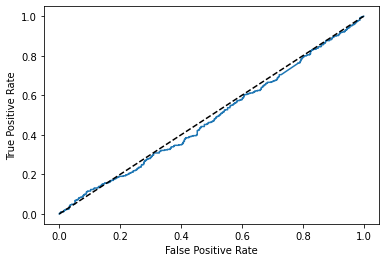

[0.16237311 0.18056936 0.18818949 0.19593058 0.2024507  0.20887778
 0.21517227 0.21851426 0.2206499  0.22115841 0.22823431 0.23013901
 0.23340842 0.23623278 0.23630433 0.23634466 0.23738572 0.23951594
 0.24808703 0.25492126 0.25680801 0.25718856 0.2585932  0.25899003
 0.25944126 0.26503231 0.26532693 0.26559536 0.2665199  0.26852878
 0.26909647 0.27080282 0.27255294 0.27261278 0.27270274 0.27283576
 0.27376518 0.27428561 0.2748541  0.27526945 0.27682017 0.27784622
 0.2785151  0.27895332 0.27948727 0.2795103  0.28037291 0.28075334
 0.28086456 0.28195035 0.28203289 0.28270719 0.2840295  0.28558015
 0.28577802 0.28640839 0.28712466 0.28788552 0.28930065 0.28978201
 0.28993961 0.29075509 0.29127917 0.29177454 0.29279887 0.29306683
 0.29445592 0.29480085 0.2948383  0.29555564 0.29594759 0.29602694
 0.2975493  0.29795756 0.29861322 0.30020051 0.30061789 0.30074156
 0.30088328 0.30090688 0.30174289 0.30186344 0.30208785 0.30230725
 0.30232524 0.30255415 0.30260372 0.30274384 0.30293503 0.3032

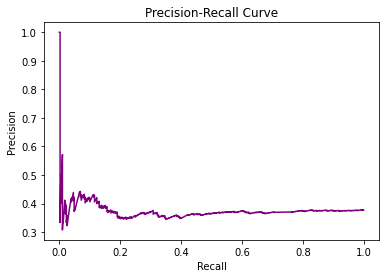

6: Out-of-bag score estimate: 0.613
6: Mean accuracy score: 0.603
6: Recall: 0.0386


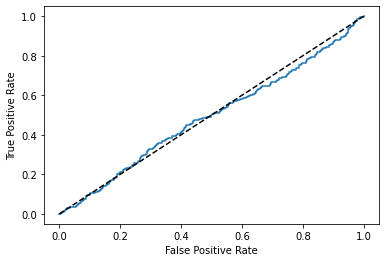

[0.17917876 0.18081826 0.18573625 ... 0.69970832 0.70780737 0.84965229]


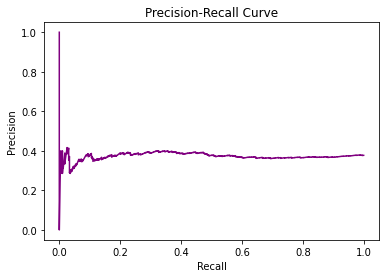

11: Out-of-bag score estimate: 0.614
11: Mean accuracy score: 0.605
11: Recall: 0.0515


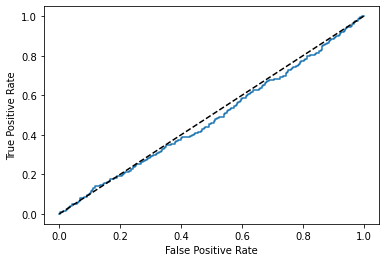

[0.17272629 0.19459985 0.21034421 ... 0.67751245 0.70400776 0.78150087]


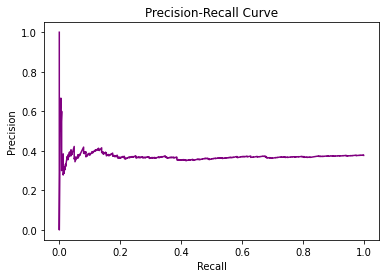

16: Out-of-bag score estimate: 0.611
16: Mean accuracy score: 0.604
16: Recall: 0.0622


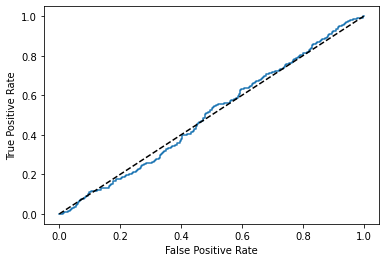

[0.10383409 0.14799194 0.1839607  ... 0.65502179 0.69900177 0.70831854]


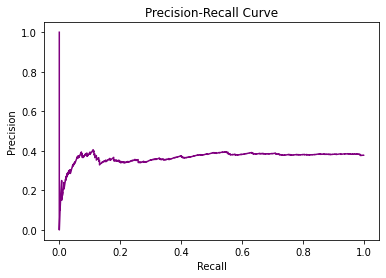

21: Out-of-bag score estimate: 0.585
21: Mean accuracy score: 0.572
21: Recall: 0.0916


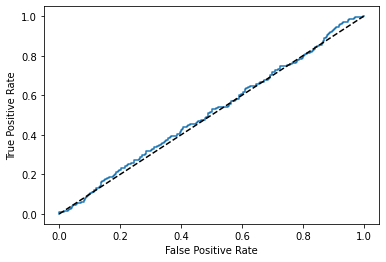

[0.07154178 0.08630986 0.0999447  0.12795622 0.14996347 0.15312804
 0.16370756 0.16984951 0.18690231 0.18756172 0.19341249 0.19888047
 0.21458262 0.21570042 0.22346697 0.22482395 0.22789589 0.23016635
 0.23037349 0.23219804 0.23416384 0.23781778 0.23933443 0.24089327
 0.24112245 0.24125649 0.24160155 0.2416739  0.24175934 0.24196715
 0.24623499 0.24727382 0.24925446 0.24927777 0.25107938 0.25262365
 0.25338614 0.25482473 0.25560364 0.25731856 0.26328499 0.26574339
 0.26921995 0.27136977 0.27137906 0.2714083  0.27145752 0.27181965
 0.27274578 0.27445459 0.27446607 0.27600335 0.27645701 0.27990662
 0.28012406 0.28015773 0.28027196 0.2805239  0.28073769 0.2809919
 0.28146674 0.28217063 0.28394618 0.28422413 0.28431559 0.2850095
 0.28703397 0.28777673 0.2878205  0.2890134  0.28928312 0.28932598
 0.28943372 0.28948566 0.28956742 0.28995938 0.29293597 0.29364757
 0.29368944 0.29412825 0.29650413 0.29739452 0.29762479 0.29809182
 0.29875894 0.2988255  0.2989862  0.29912337 0.29944263 0.299861

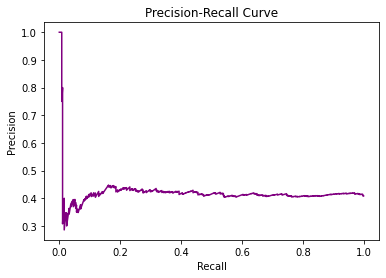

26: Out-of-bag score estimate: 0.519
26: Mean accuracy score: 0.527
26: Recall: 0.384


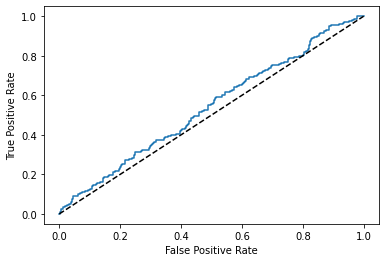

[0.12040508 0.12653366 0.12819812 0.1313347  0.1314003  0.15049744
 0.15400757 0.16202883 0.18108363 0.18361917 0.19264524 0.19874897
 0.20387961 0.2342158  0.23564627 0.23624167 0.24419264 0.24737618
 0.25714729 0.25949802 0.26151722 0.2656356  0.26915058 0.27338364
 0.27464166 0.27584208 0.28125687 0.28437865 0.28555886 0.28684431
 0.2883553  0.29220282 0.29280115 0.29293465 0.29409958 0.29819045
 0.29849957 0.29971033 0.29981971 0.30062052 0.3014586  0.30190153
 0.302854   0.31231669 0.31238851 0.31617196 0.31710019 0.31807481
 0.32295414 0.32582439 0.32694902 0.32760658 0.32765541 0.32799653
 0.32945204 0.32973648 0.33078452 0.33277418 0.33284641 0.33289775
 0.33316807 0.3334548  0.33359932 0.33387861 0.33392512 0.33417755
 0.3352238  0.33555924 0.33858701 0.33948107 0.34069718 0.34161036
 0.34183807 0.34426682 0.34582954 0.34709723 0.34735919 0.34767224
 0.34780749 0.34801962 0.34833289 0.3504409  0.3519241  0.35215529
 0.35226035 0.35267248 0.35331671 0.3534294  0.35633076 0.3565

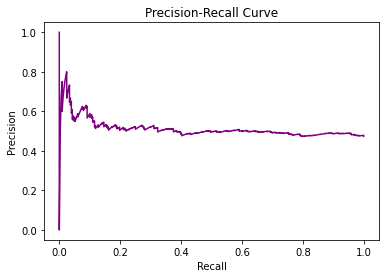

31: Out-of-bag score estimate: 0.54
31: Mean accuracy score: 0.561
31: Recall: 0.675


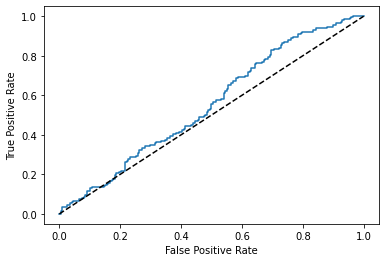

[0.07830884 0.08037271 0.13334421 0.15242937 0.20191251 0.2387141
 0.25357555 0.25610235 0.26665093 0.28749877 0.30040115 0.30948315
 0.31262788 0.3143648  0.31524905 0.31560418 0.32362267 0.32759891
 0.33169845 0.339877   0.3399926  0.34128268 0.34274529 0.34496173
 0.34776404 0.34861188 0.35184732 0.35340878 0.35760775 0.35845524
 0.36011154 0.36039443 0.363473   0.36731042 0.37077289 0.37276911
 0.37342083 0.37808958 0.38091093 0.38137672 0.38305357 0.3844545
 0.38472868 0.38916745 0.39295217 0.39649329 0.40001459 0.40027587
 0.40102365 0.40177797 0.40323386 0.40358657 0.40403029 0.4076758
 0.40914727 0.41073607 0.41097244 0.41293964 0.41515541 0.4158782
 0.41978282 0.41979529 0.42329205 0.42348108 0.42352689 0.42376671
 0.42489181 0.42577103 0.42637464 0.42639719 0.42701144 0.42813618
 0.4285227  0.42943379 0.4303832  0.43303235 0.43306676 0.43369255
 0.43560308 0.43640301 0.4372494  0.43771743 0.43820449 0.43842811
 0.43848929 0.43885604 0.43893451 0.44020111 0.44151663 0.44183804

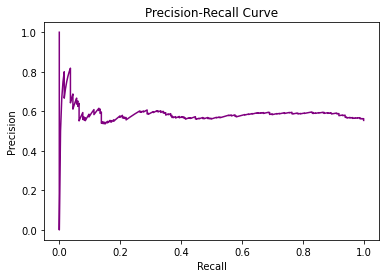

36: Out-of-bag score estimate: 0.629
36: Mean accuracy score: 0.696
36: Recall: 0.914


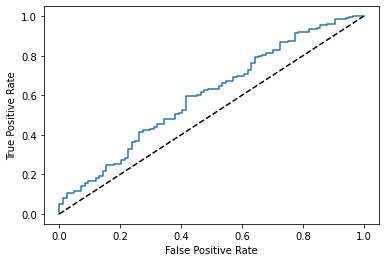

[0.15538978 0.2449493  0.27296076 0.28808663 0.29335028 0.31001326
 0.31202798 0.34738235 0.372795   0.39942836 0.4012895  0.42570832
 0.42683362 0.43126176 0.44793568 0.44850101 0.44889586 0.44937149
 0.45247558 0.45262253 0.45453931 0.45510635 0.45706023 0.45752648
 0.45859388 0.46512368 0.48170809 0.48286195 0.48639839 0.48827329
 0.49327317 0.49421144 0.49557641 0.49920058 0.50014097 0.50141041
 0.50174753 0.50745955 0.50798437 0.51146483 0.5116687  0.51372903
 0.51379481 0.51675045 0.52006722 0.52453121 0.5256741  0.53331304
 0.53394008 0.53475131 0.54461286 0.55132469 0.5532668  0.55591777
 0.55690827 0.56023964 0.56062747 0.56118325 0.5627069  0.56275131
 0.56473156 0.56474946 0.56799842 0.56812933 0.56879994 0.56999947
 0.57097378 0.57200898 0.57278705 0.57295639 0.5767491  0.57824424
 0.58029464 0.58291668 0.58314042 0.58743146 0.58816214 0.58867449
 0.59479888 0.59530669 0.59583224 0.60006067 0.60113883 0.60119177
 0.60196988 0.60208993 0.60274373 0.60370779 0.60397057 0.6043

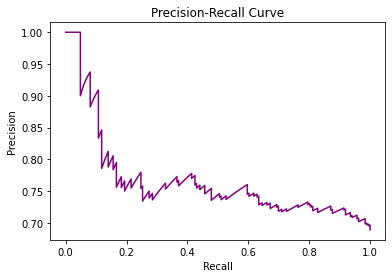

41: Out-of-bag score estimate: 0.718
41: Mean accuracy score: 0.783
41: Recall: 0.977


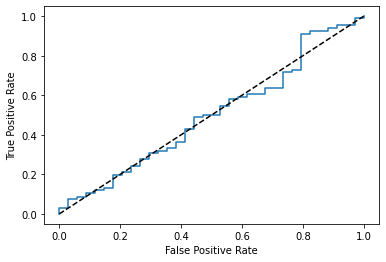

[0.39923958 0.45073746 0.49681409 0.49733153 0.51449054 0.52992108
 0.53217181 0.53593728 0.54079167 0.54372463 0.54585338 0.54598181
 0.55387249 0.55697268 0.56086404 0.56515137 0.56565365 0.57114138
 0.57894434 0.58002012 0.58167843 0.59438854 0.59527741 0.59917788
 0.60267087 0.60392947 0.60601904 0.61510911 0.61759444 0.61795021
 0.61835894 0.61984894 0.62327088 0.62405613 0.62734346 0.62992557
 0.62994139 0.63172998 0.63366764 0.63589871 0.63776846 0.6512409
 0.65550761 0.66126888 0.66168908 0.6644128  0.66580061 0.66587658
 0.6659882  0.67089079 0.67141543 0.67159016 0.67879525 0.67913533
 0.680443   0.68299935 0.68422809 0.6873434  0.68997143 0.69338364
 0.69583049 0.69639013 0.69941252 0.70201236 0.70264759 0.70280204
 0.70390833 0.70644936 0.70994212 0.71249218 0.7141857  0.71897
 0.72000703 0.72009883 0.72144162 0.72382965 0.7246544  0.72713961
 0.73026835 0.73856134 0.73925748 0.73943441 0.7396848  0.74036141
 0.74077035 0.74192739 0.74245503 0.74254122 0.74318666 0.7441377


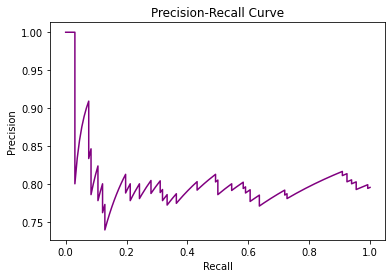

46: Out-of-bag score estimate: 0.771
46: Mean accuracy score: 0.822
46: Recall: 0.945


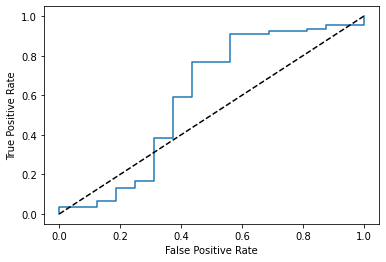

[0.30735746 0.32448645 0.37109989 0.40318207 0.46718522 0.48738774
 0.49409377 0.53034232 0.5442881  0.59942357 0.60516756 0.60848816
 0.6152392  0.62152236 0.64501086 0.64859178 0.65228545 0.65519245
 0.67098334 0.67465546 0.67746409 0.68068127 0.69568174 0.69930651
 0.69940543 0.71120227 0.72166507 0.72539827 0.72860779 0.73905095
 0.73936722 0.74147596 0.74286272 0.74472913 0.74902953 0.74995207
 0.75160578 0.75455348 0.7702239  0.77136833 0.77275131 0.77434108
 0.77474596 0.77999619 0.78248056 0.78495775 0.78554546 0.78989816
 0.79027948 0.79486686 0.80823157 0.80881959 0.80900194 0.81071732
 0.81076617 0.81117853 0.8130419  0.81718783 0.82036816 0.82384893
 0.82571217 0.83004049 0.83174673 0.83520816 0.83697128 0.83936546
 0.83955275 0.84521169 0.84546078 0.8468576  0.84861312 0.85709254
 0.85902589 0.86128713 0.8615541  0.86175101 0.87576141 0.87596834
 0.87762305 0.87897907 0.8789975  0.88044317 0.88325331 0.88573894
 0.88914951 0.89195844 0.89348549 0.89820069 0.89889452 0.9002

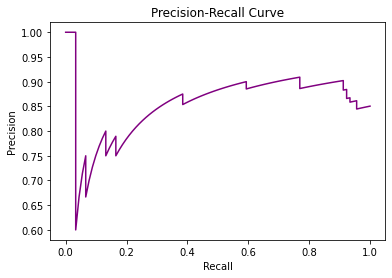

51: Out-of-bag score estimate: 0.8
51: Mean accuracy score: 0.902
51: Recall: 0.964


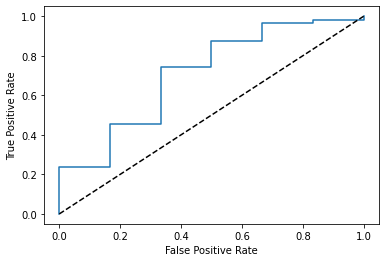

[0.25039018 0.30763636 0.31138085 0.46154142 0.51214391 0.58811465
 0.59066243 0.59353846 0.62171241 0.62252177 0.67713815 0.69181596
 0.69283185 0.71809238 0.73276891 0.74675455 0.75308617 0.75354508
 0.76320949 0.76534609 0.76760286 0.79382845 0.79421261 0.79537563
 0.79745441 0.80265622 0.80275567 0.80982195 0.81084965 0.811157
 0.82541827 0.82681527 0.8314707  0.84133525 0.84622917 0.84726817
 0.8508563  0.85462773 0.86583458 0.8670012  0.87083625 0.87299804
 0.87481507 0.87850375 0.87891429 0.88501798 0.88702168 0.88840356
 0.89564389 0.89612174 0.89688543 0.90925791 0.91388523 0.91910061
 0.92780917 0.93246455 0.93514392 0.94486271 0.95433454 0.97205715
 0.98527308]


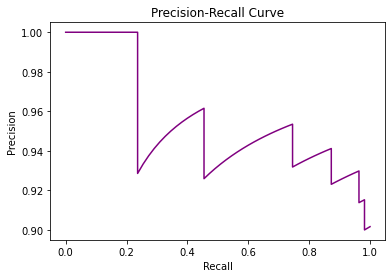

56: Out-of-bag score estimate: 0.774
56: Mean accuracy score: 0.829
56: Recall: 0.933


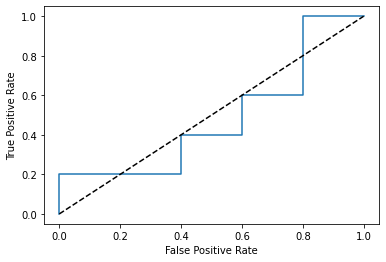

[0.37307316 0.41117113 0.48839048 0.607      0.60982353 0.62406667
 0.67887619 0.67940865 0.68692381 0.696      0.732      0.73342857
 0.73677476 0.7414     0.75       0.76059533 0.76061048 0.76376457
 0.764      0.76669508 0.76961905 0.77497613 0.77966667 0.808
 0.81       0.81480952 0.836      0.83643918 0.8456019  0.84622727
 0.856      0.9285977  0.94       0.94390476 0.94847619]


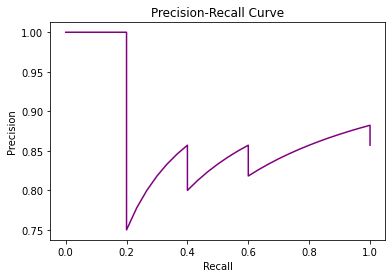

In [49]:
evaluate(clean_test_df_dict_force_simple, models_force_simple)

1: Out-of-bag score estimate: 0.616
1: Mean accuracy score: 0.625
1: Recall: 0.0848


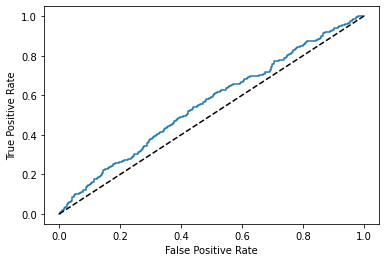

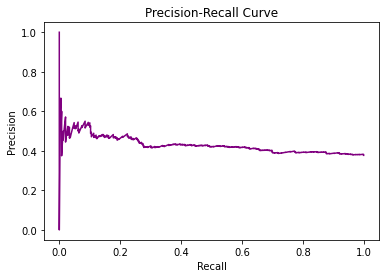

6: Out-of-bag score estimate: 0.615
6: Mean accuracy score: 0.61
6: Recall: 0.0848


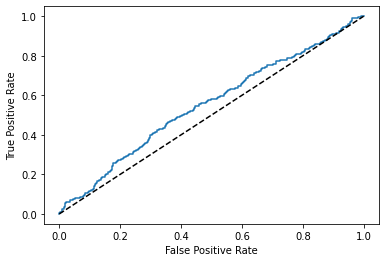

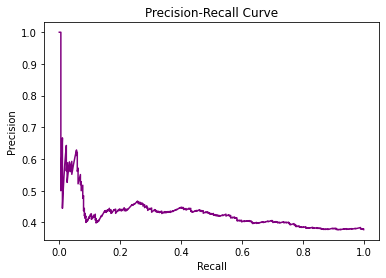

11: Out-of-bag score estimate: 0.616
11: Mean accuracy score: 0.619
11: Recall: 0.0464


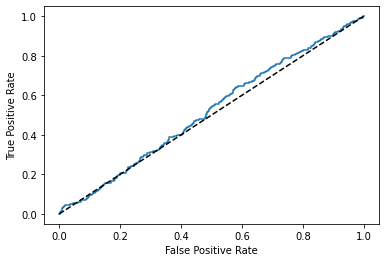

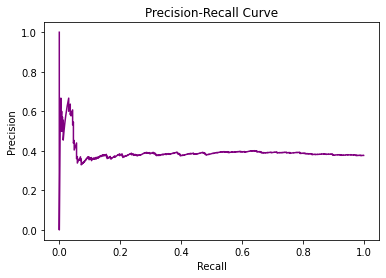

16: Out-of-bag score estimate: 0.615
16: Mean accuracy score: 0.626
16: Recall: 0.0622


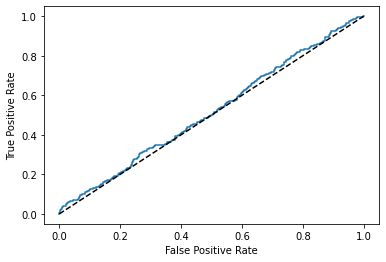

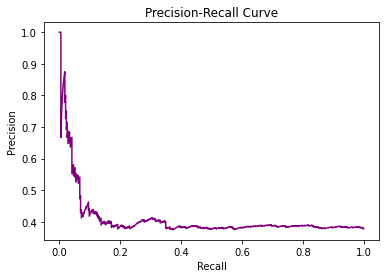

21: Out-of-bag score estimate: 0.622
21: Mean accuracy score: 0.604
21: Recall: 0.272


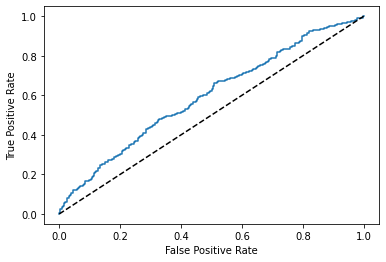

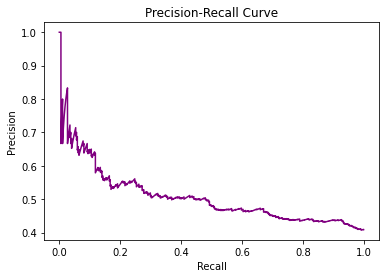

26: Out-of-bag score estimate: 0.631
26: Mean accuracy score: 0.619
26: Recall: 0.491


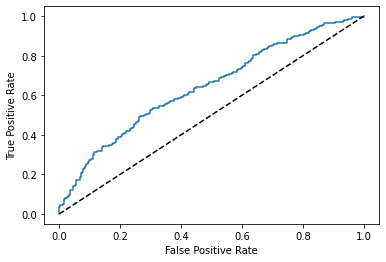

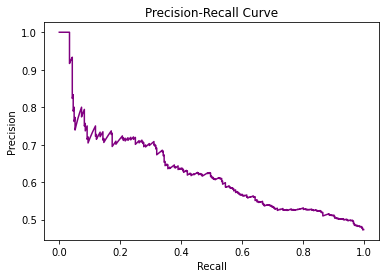

31: Out-of-bag score estimate: 0.662
31: Mean accuracy score: 0.649
31: Recall: 0.679


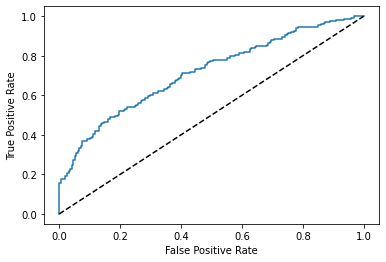

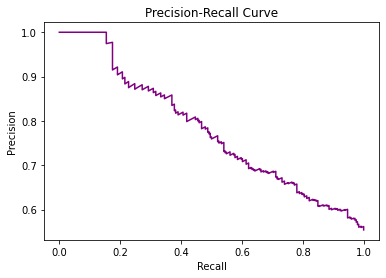

36: Out-of-bag score estimate: 0.69
36: Mean accuracy score: 0.733
36: Recall: 0.876


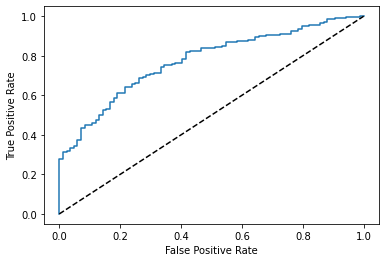

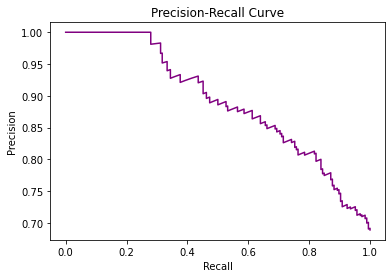

41: Out-of-bag score estimate: 0.731
41: Mean accuracy score: 0.753
41: Recall: 0.909


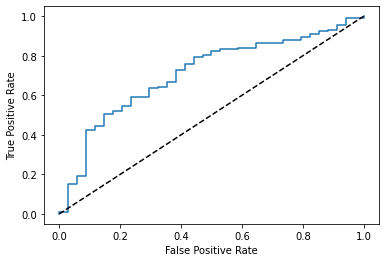

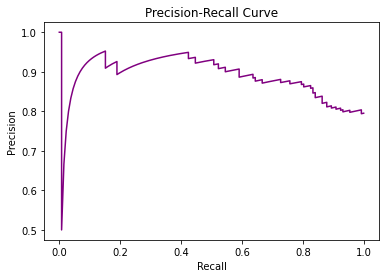

46: Out-of-bag score estimate: 0.788
46: Mean accuracy score: 0.804
46: Recall: 0.923


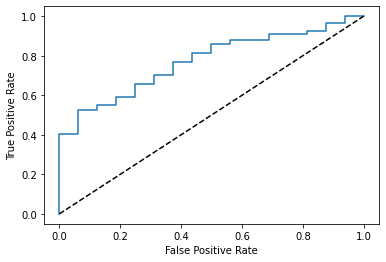

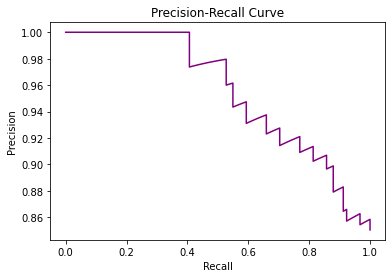

51: Out-of-bag score estimate: 0.82
51: Mean accuracy score: 0.852
51: Recall: 0.927


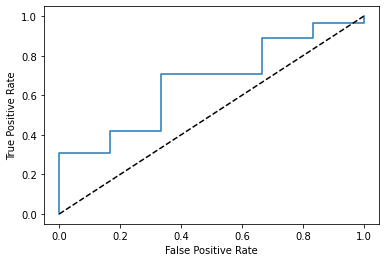

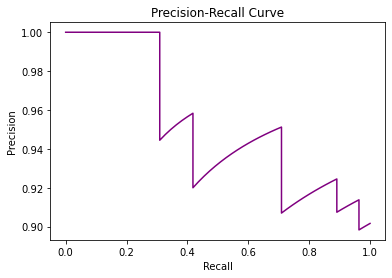

56: Out-of-bag score estimate: 0.786
56: Mean accuracy score: 0.8
56: Recall: 0.933


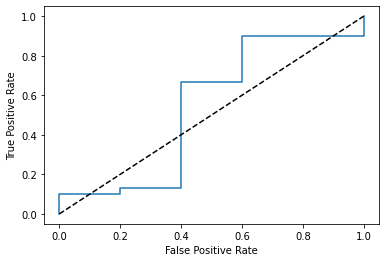

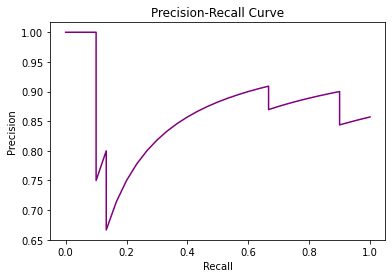

In [47]:
evaluate(clean_test_df_dict_dist, models_force_dist)